# Parcels Tutorial
## (adapted for Particle Release snippets example)

In this tutorial, we show different methods to release particles.  For this we use the tutorial:  https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/parcels_tutorial.ipynb#Reading-in-data-from-arbritrary-NetCDF-files
<br>
We focus on the part on how to [run particles in a set of NetCDF files from external data](#Reading-in-data-from-arbritrary-NetCDF-files). 

The dataset can be found here: https://github.com/OceanParcels/oceanparcels_website/tree/master/examples-data

The different particle release methods show below are: 
* [1. Releasing particles on a line](#1.-Releasing-particles-on-a-line)
* [2. Mesh grid in degrees](#2.-Mesh-grid-in-degrees)
* [3. Mesh grid in km](#3.-Mesh-grid-in-km)
* [4. 1 particle per fieldset grid point](#4.-1-particle-per-fieldset-grid-point)
* [5. Siren Ruhs' example](#5.-Siren-Ruhs'-example)
* [6. Victor Onink's example 01](#6.-Victor-Onink's-example-01)
* [7. Mikael Kaandorp's example](#7.-Mikael-Kaandorp's-example)
* [8. Victor Onink's example 02](#8.-Victor-Onink's-example-02)

In [1]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter

## Reading in data from arbritrary NetCDF files

In most cases, you will want to advect particles within pre-computed velocity fields. If these velocity fields are stored in NetCDF format, it is fairly easy to load them into the `FieldSet.from_netcdf()` function.

The `examples` directory contains a set of [GlobCurrent](http://globcurrent.ifremer.fr/products-data/products-overview) files of the region around South Africa.

First, define the names of the files containing the zonal (U) and meridional (V) velocities. You can use wildcards (`*`) and the filenames for U and V can be the same (as in this case)

In [2]:
filedir_root = '/nethome/gomez023/git/oceanparcels_website/examples-data/'


In [3]:
!ncdump -h /nethome/gomez023/git/oceanparcels_website/examples-data/GlobCurrent_example_data/20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc

netcdf \20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0 {
dimensions:
	lon = 81 ;
	lat = 41 ;
	time = UNLIMITED ; // (1 currently)
variables:
	double lon(lon) ;
		lon:Unit = "degrees" ;
	double lat(lat) ;
		lat:Unit = "degrees" ;
	double time(time) ;
		time:Unit = "days since 1900-1-1" ;
	double eastward_eulerian_current_velocity(time, lat, lon) ;
		eastward_eulerian_current_velocity:Unit = "m s-1" ;
	double northward_eulerian_current_velocity(time, lat, lon) ;
		northward_eulerian_current_velocity:Unit = "m s-1" ;
}


In [4]:
filenames = {'U': filedir_root + "GlobCurrent_example_data/20*.nc",
             'V': filedir_root + "GlobCurrent_example_data/20*.nc"}

Then, define a dictionary of the variables (`U` and `V`) and dimensions (`lon`, `lat` and `time`; note that in this case there is no `depth` because the GlobCurrent data is only for the surface of the ocean)

In [5]:
variables = {'U': 'eastward_eulerian_current_velocity',
             'V': 'northward_eulerian_current_velocity'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}

Finally, read in the fieldset using the `FieldSet.from_netcdf` function with the above-defined `filenames`, `variables` and `dimensions`

In [6]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

# 1. Releasing particles on a line

Now define a `ParticleSet`, in this case with 5 particle starting on a line between (28E, 33S) and (30E, 33S) using the `ParticleSet.from_line` constructor method

In [12]:
pset = ParticleSet.from_line(fieldset=fieldset, pclass=JITParticle,
                             size=5,            # releasing 5 particles
                             start=(28, -33),   # releasing on a line: the start longitude and latitude
                             finish=(30, -33))  # releasing on a line: the end longitude and latitude

And finally execute the `ParticleSet` for 10 days using 4th order Runge-Kutta

In [13]:
output_file = pset.ParticleFile(name="GlobCurrentParticles.nc", outputdt=timedelta(hours=6))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=10),
             dt=timedelta(minutes=5),
             output_file=output_file)

sh: None: command not found
INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-319202/lib81b1bef921f6c740bb82c58d4743f273_0.so


Now visualise this simulation using the `plotParticles` script again. Note you can plot the particles on top of one of the velocity fields using the `tracerfile`, `tracerfield`, etc keywords.

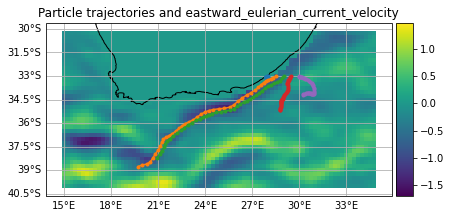

In [15]:
output_file.export()
plotTrajectoriesFile('GlobCurrentParticles.nc',
                     tracerfile=filedir_root + 'GlobCurrent_example_data/20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='eastward_eulerian_current_velocity');

# 2. Mesh grid in degrees

In [10]:
lons, lats = np.meshgrid(range(28, 32), range(-36, -33)) # 1 degree step
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)

In [11]:
output_file = pset.ParticleFile(name="GlobCurrentParticles_mesh_degs.nc", outputdt=timedelta(hours=6))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=10),
             dt=timedelta(minutes=5),
             output_file=output_file)

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/54/mb8qg4_j53d9_q2jnv7n8sjc0000gn/T/parcels-501/b359745175a19dbd6ed894124935df4f_0.so


/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:224: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cs.cmap.set_over('k')
/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/parce

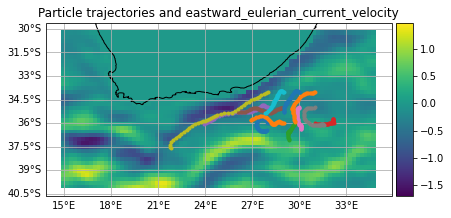

In [12]:
output_file.export()
plotTrajectoriesFile('GlobCurrentParticles_mesh_degs.nc',
                     tracerfile='GlobCurrent_example_data/20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='eastward_eulerian_current_velocity');

# 3. Mesh grid in km

In [ ]:
# unit_converter --> example tutorial

# 4. 1 particle per fieldset grid point

In [19]:
fieldset.U.lat.shape

(41,)

In [22]:
lon1D = fieldset.U.lon[40:50]
lat1D = fieldset.U.lat[10:20]

lons, lats = np.meshgrid(lon1D, lat1D) 
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)


In [23]:
output_file = pset.ParticleFile(name="GlobCurrentParticles_1part_gridpoint.nc", outputdt=timedelta(hours=6))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=10),
             dt=timedelta(minutes=5),
             output_file=output_file)

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/54/mb8qg4_j53d9_q2jnv7n8sjc0000gn/T/parcels-501/04ea0f77b1ce57beb2392a18443eb31b_0.so


/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:224: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cs.cmap.set_over('k')
/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/parce

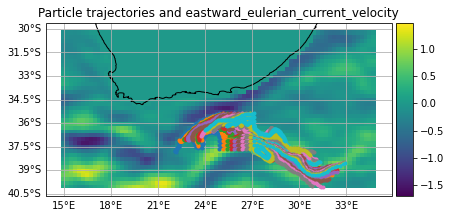

In [24]:
output_file.export()
plotTrajectoriesFile('GlobCurrentParticles_1part_gridpoint.nc',
                     tracerfile='GlobCurrent_example_data/20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='eastward_eulerian_current_velocity');

# 5. Siren Ruhs' example
(deleting particles released on land)

### Kernels adapted from:
https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts/blob/master/northsea_mp_kernels.py

This beaching kernel used here and its defined land points use a "simple go-to" method that might not suffice in all cases.  In case of problems get in contact via the issue tracker on github.

In [7]:
lon_min = 24
lon_max = 28
lat_min = -35
lat_max = -32
lons, lats = np.meshgrid(range(lon_min, lon_max), range(lat_min, lat_max)) # 1 degree step


In [8]:
pclass=JITParticle # scipy works too

In [9]:
class BeachParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable('beached', dtype=np.int64, initial=2)

In [10]:
def BeachTesting(particle, fieldset, time):
    vel_threshold = 1e-14 # value depending on fieldset used and how variable is stored
    
    if particle.beached == 2:
        (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        if math.fabs(u) < vel_threshold and math.fabs(v) < vel_threshold: 
            particle.beached = 1
            print("Particle [%d] beached !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
        else:
            particle.beached = 0


In [11]:
def DeleteParticle(particle, fieldset, time):
    if particle.beached == 1:
        particle.delete()
        print("Particle [%d] deleted !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))

In [12]:
def PlotParticleSet(pset, fieldset):
    plotstep=2
    pset.show(field=fieldset.U,
              domain={'N':(lat_max+plotstep/2), 'S':(lat_min-plotstep),
                      'E':(lon_max+plotstep), 'W':(lon_min-plotstep)})

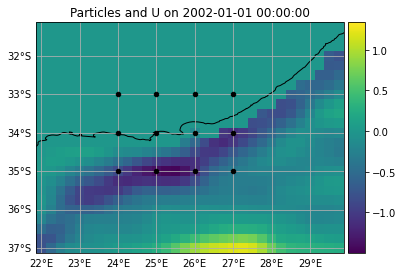

maximum number of release positions (including land): 12



sh: None: command not found
INFO: Compiled ArrayBeachParticleBeachTestingDeleteParticle ==> /tmp/parcels-319202/lib0742c00d793e8f09b53bf72450c60afb_0.so


Particle [4] beached !! (24 -34 0 0)
Particle [8] beached !! (24 -33 0 0)
Particle [9] beached !! (25 -33 0 0)
Particle [10] beached !! (26 -33 0 0)
Particle [11] beached !! (27 -33 0 0)


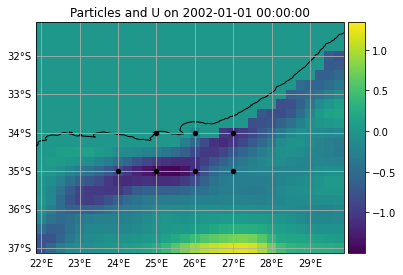

actual number of release positions (excluding land): 7
actual number of particles: 7


In [13]:
fieldset_init = FieldSet.from_netcdf(filenames, variables, dimensions)

# release particles on predefined uniform grid, including land grid points
pset_init = ParticleSet(fieldset=fieldset_init,
                   pclass=BeachParticle,
                   lon=lons, lat=lats, time=0)
pset_init.populate_indices()
PlotParticleSet(pset_init, fieldset_init)
print('maximum number of release positions (including land):', pset_init.lon.size)
print()

# perform a "fake" integration to determine and delete particles released on land
## by making use of beach-testing and deleting kernels
## (without advection kernel)
kernels_init = pset_init.Kernel(BeachTesting) + pset_init.Kernel(DeleteParticle)
pset_init.execute(kernels_init, dt=0)
PlotParticleSet(pset_init, fieldset_init)

# retrieve lon and lats from all ocean release positions
print('actual number of release positions (excluding land):', pset_init.lon.size)
print('actual number of particles:',
      pset_init.lon.size )#* ((tend_release-tstart_release)/deltat_release))
lons_use = pset_init.lon
lats_use = pset_init.lat


In [14]:
pset_init

P[0](lon=24.000000, lat=-35.000000, depth=0.000000, beached=0.000000, time=0.000000)
P[1](lon=25.000000, lat=-35.000000, depth=0.000000, beached=0.000000, time=0.000000)
P[2](lon=26.000000, lat=-35.000000, depth=0.000000, beached=0.000000, time=0.000000)
P[3](lon=27.000000, lat=-35.000000, depth=0.000000, beached=0.000000, time=0.000000)
P[5](lon=25.000000, lat=-34.000000, depth=0.000000, beached=0.000000, time=0.000000)
P[6](lon=26.000000, lat=-34.000000, depth=0.000000, beached=0.000000, time=0.000000)
P[7](lon=27.000000, lat=-34.000000, depth=0.000000, beached=0.000000, time=0.000000)

In [25]:
fieldset_main = FieldSet.from_netcdf(filenames, variables, dimensions)

# release particles on predefined uniform grid, including land grid points
pset_main = ParticleSet(fieldset=fieldset_main,
                   pclass=JITParticle,
                   lon=lons_use, lat=lats_use, time=0)


In [26]:
output_file = pset_main.ParticleFile(name="GlobCurrentParticles_del_particles_land.nc", outputdt=timedelta(hours=6))
pset_main.execute(AdvectionRK4,
                  runtime=timedelta(days=2),
                  dt=timedelta(minutes=5),
                  output_file=output_file)

sh: None: command not found
INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-319202/libcffe17060997c6cff86ef7f1fb03c8b0_0.so


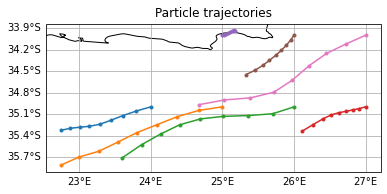

In [27]:
output_file.export()
plotTrajectoriesFile('GlobCurrentParticles_del_particles_land.nc',
                     #tracerfile='GlobCurrent_example_data/20020101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc',
                     tracerlon='lon',
                     tracerlat='lat',
                     tracerfield='eastward_eulerian_current_velocity');

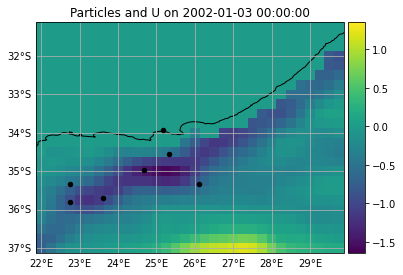

In [28]:
PlotParticleSet(pset_main, fieldset_main)


# Below more complex examples are shown:

# 6. Victor Onink's example 01

https://github.com/OceanParcels/SKIM-garbagepatchlocations/blob/master/Global/globalGrid.py

```
#!/usr/bin/env python2
# -- coding: utf-8 --
"""
Created on Fri Jan  5 17:21:28 2018
Function to generate a uniform (in degree) grid of particles for initial positions
for the Global basin
@author: David Wichmann, modified by Victor Onink
"""

import numpy as np
from parcels import Field
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def GetGlobCurrentLandArray(filename, fieldname):
    """
    Function to return a Field with 1's at land points and 0's at ocean points, based on python basemap
    :param f: a field of the .nc file, but not a parcels field object! For OFES, land points are masked. This is used here!
    """
    pfile = Dataset(filename, 'r')
    Lon = pfile.variables['lon'][:]
    Lat = pfile.variables['lat'][:]
    f = pfile.variables[fieldname][:]
    f = f[0]
    L= np.ma.getmask(f)
    Land=Field('Land',L,transpose=False,lon=Lon,lat=Lat)
    return Land

def Plotdistr():
#    lons=np.load('D:\Desktop\Thesis\ParcelsFigData\Data\North Atlantic\InputArray/NA_TM_LonsInitial_ddeg02.npy')
#    lats=np.load('D:\Desktop\Thesis\ParcelsFigData\Data\North Atlantic\InputArray/NA_TM_LatsInitial_ddeg02.npy')
#    lons= np.load('/Users/wichmann/sources/inertialparticles_David/paper/1_Distribution/ParticleGrid/Lons_N1275_NA_deg2.npy')
#    lats = np.load('/Users/wichmann/sources/inertialparticles_David/paper/1_Distribution/ParticleGrid/Lats_N1275_NA_deg2.npy')
#    slons= np.load('/Users/wichmann/sources/inertialparticles_David/paper/1_Distribution/ParticleGrid/Lons_N1275_NA_deg2_shift.npy')
#    slats = np.load('/Users/wichmann/sources/inertialparticles_David/paper/1_Distribution/ParticleGrid/Lats_N1275_NA_deg2_shift.npy')
print lons[lons<0.]
#    print slons[slons<0.]
#
#    m = Basemap(projection='merc', llcrnrlat=0.,  urcrnrlat=75., llcrnrlon=-60.0, urcrnrlon=360., resolution='l')
#    m.drawcoastlines()
#    xs, ys = m(lons, lats)
#    m.scatter(xs,ys)
#Plotdistr()

def GenerateP(landfilename, lonmin, lonmax, latmin, latmax, spacing, name):
    Land = GetGlobCurrentLandArray(landfilename, 'northward_eulerian_current_velocity')
    grid=np.mgrid[lonmin:lonmax:spacing,latmin:latmax:spacing]
    n=grid[0].size;
    lons=np.reshape(grid[0],n)
    lats=np.reshape(grid[1],n)
    print 'number of particles beginning: ', len(lats)
    #Remove land particles and mdeiterranean particles
    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if Land[0,lo,la,0]==0.0  ]),np.array([la for lo, la in zip(lons,lats) if Land[0,lo,la,0]==0.0 ])]
    #    #Remove pacific part
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< - lo - 75)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< - lo - 75)])]
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 10 and lo<-70)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< 10 and lo<-70)])]
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 15 and lo<-83)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< 15 and lo<-83)])]
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 12 and lo<-82)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< 12 and lo<-82)])]
    #
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la> 50 and -70<lo<-20)  ]),np.array([la for lo, la in zip(lons,lats) if not (la> 50 and -70<lo<-20)])]
    #    #Remove mediterranian
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 48 and la > 30 and lo >0)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< 48 and la > 30 and lo >0)])]
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la< 39 and la > 35 and lo >-7)  ]),np.array([la for lo, la in zip(lons,lats) if not (la< 39 and la > 35 and lo >-7)])]
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (lo<5. and lo>-5 and la<41 and la>35)  ]),np.array([la for lo, la in zip(lons,lats) if not (lo<5. and lo>-5 and la<41 and la>35)])]
    #
    #    #remove some parts in canada
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la> 50 and la<72 and lo < -70)  ]),np.array([la for lo, la in zip(lons,lats) if not (la> 50  and la<72 and lo < -70)])]
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (lo < -78 and la > 71)  ]),np.array([la for lo, la in zip(lons,lats) if not (lo < -78 and la > 71)])]
    #
    #    #Remove Ostsee
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la<65 and lo > 10)  ]),np.array([la for lo, la in zip(lons,lats) if not (la<65 and lo > 10)])]
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if not (la>60 and la<67 and lo > 20)  ]),np.array([la for lo, la in zip(lons,lats) if not (la>60 and la<67 and lo > 20)])]
    #    [lons,lats]=[np.array([lo for lo, la in zip(lons,lats) if Land[0,lo,la,0]==0.0 and not (lo>354. and la<40. and la>30.) and not (lo<288. and la>50.)  and not (lo<295.5 and lo>290. and la>57.) and not (lo<283. and la<8.6) and not (lo>357. and la> 52.)]),np.array([la for lo, la in zip(lons,lats) if Land[0,lo,la,0]==0.0 and not (lo>354. and la<40. and la>30.) and not (lo<288. and la>50.) and not (lo<295.5 and lo>290. and la>57.) and not (lo<283. and la<8.6) and not (lo>357. and la>52.)])]
    
    print 'number of particles end: ', len(lats)

    #Plot particles and density to check if it is correct
    fig = plt.figure(figsize=(22, 16))
    ax = fig.add_subplot(211)
    ax.set_title("Particles")
    m = Basemap(projection='merc', llcrnrlat=latmin,  urcrnrlat=latmax, llcrnrlon=lonmin, urcrnrlon=lonmax, resolution='l')
    m.drawparallels(np.array([20,40,60]), labels=[True, False, False, True])
    m.drawmeridians(np.array([280,300,320,340,360,380]), labels=[False, False, False, True])
    m.drawcoastlines()
    xs, ys = m(lons, lats)
    m.scatter(xs,ys)
    
    ax = fig.add_subplot(212)
    ax.set_title("Particles per bin. Should be 1 everywhere but on land.")
    m = Basemap(projection='merc', llcrnrlat=latmin,  urcrnrlat=latmax, llcrnrlon=lonmin, urcrnrlon=lonmax, resolution='l')
    m.drawcoastlines()
    lon_bins = np.arange(lonmin, lonmax, spacing)
    lat_bins = np.arange(latmin, latmax, spacing)
    density, _, _ = np.histogram2d(lats, lons, [lat_bins, lon_bins])
    lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)
    xs, ys = m(lon_bins_2d, lat_bins_2d)
    plt.pcolormesh(xs, ys, density,cmap=plt.cm.RdBu_r)
    cbar = plt.colorbar(orientation='vertical', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
    cbar.set_label('Particles per bin',size=8)
    
    #    np.save('D:\Desktop\Thesis\ParcelsFigData\Data\Global\InputArray/Lons' + name,lons)
    #    np.save('D:\Desktop\Thesis\ParcelsFigData\Data\Global\InputArray/Lats' + name,lats)
    plt.show()

landfilename = "D:\Desktop\Thesis\Data sets\GlobCurrent/2005/AllTogether/20050101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc"
lonmin, lonmax = -179.75, 179.75
latmin, latmax = -75, 75.
spacing = 1
name = 'GeoTestgrid5x5'
GenerateP(landfilename, lonmin, lonmax, latmin, latmax, spacing, name)
```

# 7. Mikael Kaandorp's example

releasing particles uniformly on the uber h3 grid (and removing particles on land), my code can be found here:
https://github.com/OceanParcels/Global_Analysis_Mikael/blob/main/create_release_uniform_h3.py

# 8. Victor Onink's example 02

I also remembered i have the code above, which you can use to release particles in the nearest coastal cell (starting for example from riverine inputs or population data). This might be useful for some people as well 

https://github.com/VictorOnink/Lagrangian-Transport-Scenarios/blob/master/src/advection_scenarios/create_input_files.py